# **Mixture of Experts (MoE)**

Real-world engineering processes are often complex, with underlying patterns and behaviors that can vary significantly across different contexts. Modeling these processes effectively requires approaches that can handle such variability and adapt to different scenarios dynamically. In the world of Gaussian Proccesses (GPs) one powerful method for achieving this is the Mixture of Experts model.

A Mixture of Experts model combines multiple expert models to handle different parts of the input space. Each expert is specialized in a particular region or aspect of the data, and a gating network decides which expert (or combination of experts) should be used for a given input. This modular approach allows for more flexible and accurate modeling of complex data.

This notebook will first illustrate how a Mixture of Experts model might be useful, and then cover how to use one in `twinLab`:

1. [Limitations of classic Gaussian Processes.](#1-limitations-of-classic-stationary-Gaussian-Procceses)
2. [Upload your dataset to the cloud.](#2.1-Upload-dataset-to-be-used)
3. [Train a Mixture of Experts emulator.](#2.2-Train-your-emulator)
4. [Plot the results of your Mixture of Experts trained emulator.](#2.3-Plot-the-results-of-trained-emulator)
5. [Predict using a Mixture of Experts emulator.](#2.4-Predict-using-your-trained-emulator)
6. [Compare the prediction results of a Mixture of Experts emulator and a standard emulator.](#2.5.-Viewing-and-comparing-the-results)
  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.12.0
          User        : jamie@digilab.co.uk
          Server      : https://twinlab.digilab.co.uk/v3
          Environment : /Users/jamiedonald-mccann/Desktop/twinLab/tutorials/.env



Make sure you set up your API key and other information to be able to use `twinLab`, either through a `.env` file, using `secrets`, or through `tl.set_user`/`tl.set_api_key`.

### **1. Limitations of classic Gaussian Procceses**

Consider you have an underlying data-generating process, that varies a lot in one part of the data, but less so in other parts of the data. You can generate data like that through the code in the below cell.

In [2]:
# Define a random seed to ensure your data is randomly generated
np.random.seed(421)


# Define the model that generates the data
def model(x):
    y = (np.sin(np.pi * x / 5) + 0.2 * np.cos(4 * np.pi * x / 5)) * (x <= 9.6)
    lin = x > 9.6
    y[lin] = -1 + x[lin] / 10
    return y


# Create an input (X) and output (y)
X = np.linspace(0, 20, 100)
y = model(X)

We've taken this model as an example from the following paper: _Gramacy, R. B. (2020). Surrogates: Gaussian process modeling, design, and optimization for the applied sciences. CRC Press, Taylor & Francis Group._

Let's define some data from this model and prepare it in a `pandas DataFrame`, which the primary way `twinLab` expects to deal with data. 

In [3]:
# Define some data
X_data = 20 * np.random.uniform(size=50)
y_data = model(X_data) + 0.1 * np.random.normal(size=X_data.size)
class_data = (X_data > 9.6).astype("float")
df = pd.DataFrame({"X": X_data, "y": y_data, "class": class_data})

Now you can plot that data to better visualize what's going on. 

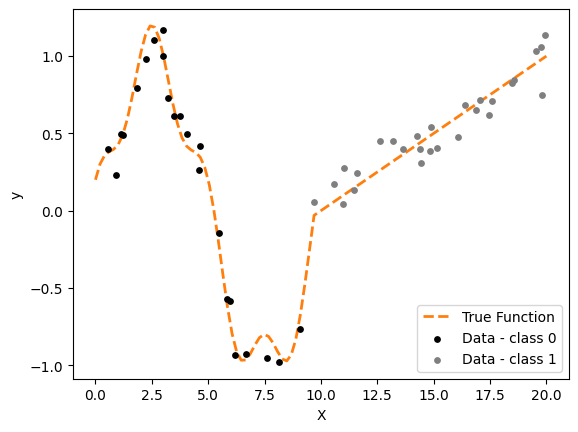

In [4]:
# Plot true function
plt.plot(
    X,
    y,
    linewidth=2,
    label="True Function",
    color="tab:orange",
    linestyle="dashed",
    zorder=1,
)
# Plot data from class 0
plt.scatter(
    X_data[class_data == 0],
    y_data[class_data == 0],
    label="Data - class 0",
    color="k",
    s=15,
)
# Plot data from class 1
plt.scatter(
    X_data[class_data == 1],
    y_data[class_data == 1],
    label="Data - class 1",
    color="tab:grey",
    s=15,
)
# Add legend and reference
plt.legend(loc="lower right")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

Create a `Dataset` with an `id` which is used to access it. Using the `upload` method, you can then upload the `Dataset` to your `twinLab` cloud account.

In [5]:
# Initialise a Dataset object and give it a name
dataset = tl.Dataset("mixture_of_experts_df")

# Upload the dataset, passing in the dataframe
dataset.upload(df)

Use the `twinLab` `Emulator` class to define an emulator with an `id`, under which your emulator will be saved as in the `twinLab` cloud.

In [6]:
emulator = tl.Emulator(id="classic_gp_emulator")

Train your model using the `Emulator.train` function, specifying your dataset, inputs, and outputs.

In [7]:
# Train a standard stationary GP emulator
emulator.train(dataset, inputs=["X"], outputs=["y"])

Emulator 'classic_gp_emulator' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: success
Training of emulator classic_gp_emulator is complete!


Visualize your results with `twinLab`. 

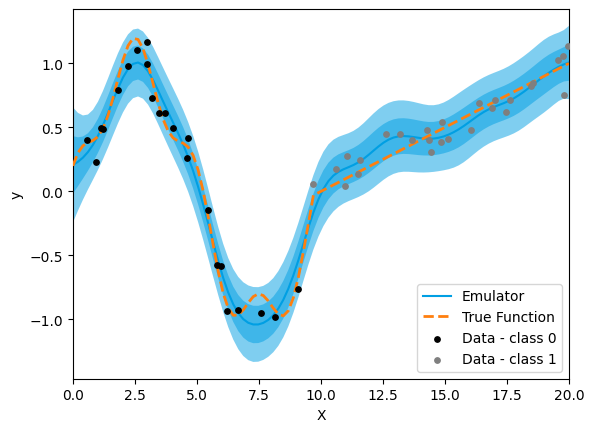

In [8]:
# Plot the emulator prediction
emulator.plot(x_axis="X", y_axis="y", x_lim=(0, 20))
# Plot true function
plt.plot(
    X,
    y,
    linewidth=2,
    label="True Function",
    color="tab:orange",
    linestyle="dashed",
    zorder=10,
)
# Plot data from class 0
plt.scatter(
    X_data[class_data == 0],
    y_data[class_data == 0],
    label="Data - class 0",
    color="k",
    s=15,
    zorder=11,
)
# Plot data from class 1
plt.scatter(
    X_data[class_data == 1],
    y_data[class_data == 1],
    label="Data - class 1",
    color="tab:grey",
    s=15,
    zorder=12,
)
plt.legend()
plt.show()

The emulator plot shows that the model has a very high predictive variance on the right side of the domain. This happens because the model is only considering functions that fits all the data points, no matter how the patterns changes depending on the input area.

Using a Mixture of Experts model will account for the different regions and patterns of the datapoints, fitting specialized ("expert") GPs to them. 

## **2. How to use `twinLab` to create, train, and use a Mixture of Experts model**

You can now create and train a `twinLab` emulator that uses a Mixture of Experts model with the same model you've just set up. 

### **2.1. Upload dataset to be used**

First, note that you will need the different classes, that are governed by different experts, to be labelled in the training `DataFrame` in advance. Here, they are specified in the "class" column:

In [9]:
# Structure of the dataframe to be uploaded
df.head()

,X,y,class
0,13.655640,0.402193,1.0
1,16.066217,0.477974,1.0
2,1.125503,0.496038,0.0
3,19.769547,1.056062,1.0
4,4.050445,0.498828,0.0


Once again, you need to create a `Dataset` with an `id` which is used to access it. Using the `upload` method, you can then upload the `Dataset` to your `twinLab` cloud account.

In [10]:
# Create your Dataset object and upload data
dataset = tl.Dataset(id="mixture_of_experts_df")
dataset.upload(df)

### **2.2. Train your emulator**

To train a Mixture of Experts models in **twinLab** you will have to:

* Specify the type of estimator you want (`"mixture_of_experts_gp"`) inside `tl.EstimatorParams()`
* Specify the label of the class column (in this case `"class"`) inside `tl.TrainParams()`
* Include the defined `tl.TrainParams()` inside the training process of the emulator along with the inputs and outputs to be considered from the dataset.

In [11]:
# Set up your emulator
emulator_MoE = tl.Emulator(id="mixture_of_experts_emulator")

# Train the emulator
estimator_params = tl.EstimatorParams(
    estimator_type="mixture_of_experts_gp"
)  # Specify the type of estimator
train_params = tl.TrainParams(
    estimator_params=estimator_params, class_column="class"
)  # Specify the label of the class column that will be used to train the different experts
emulator_MoE.train(
    dataset, inputs=["X"], outputs=["y"], params=train_params
)  # Add train_params as a parameter

Emulator 'mixture_of_experts_emulator' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: success
Training of emulator mixture_of_experts_emulator is complete!


### **2.3. Plot the results of trained emulator**

To visualize how the emulator fits the trained data you can use the plot functionality of `twinLab`. 

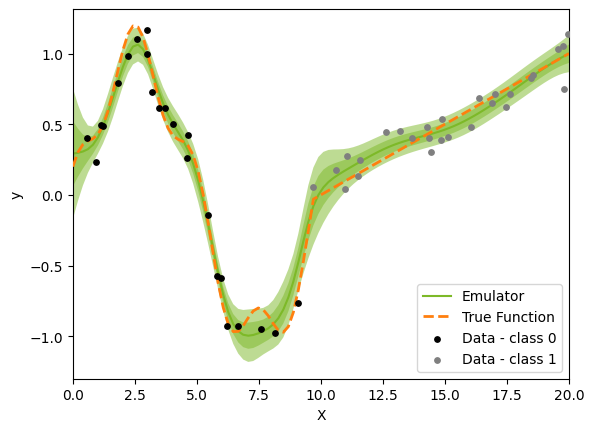

In [12]:
# Plot the emulator prediction
emulator_MoE.plot(x_axis="X", y_axis="y", x_lim=(0, 20), color="#7DB928")
# Plot true function
plt.plot(
    X,
    y,
    linewidth=2,
    label="True Function",
    color="tab:orange",
    linestyle="dashed",
    zorder=10,
)
# Plot data from class 0
plt.scatter(
    X_data[class_data == 0],
    y_data[class_data == 0],
    label="Data - class 0",
    color="k",
    s=15,
    zorder=11,
)
# Plot data from class 1
plt.scatter(
    X_data[class_data == 1],
    y_data[class_data == 1],
    label="Data - class 1",
    color="tab:grey",
    s=15,
    zorder=12,
)
plt.legend()
plt.show()

As you can see, the twinLab Mixture of Experts model fits the training data better than the previous image where a standard stationary GP was used.

### **2.4. Predict using your trained emulator**

Once the emulator is trained, the `twinLab` Mixture of Experts is ready to be used.

Now you can predict the outcome for a new set of datapoints and compare the results with the predictions coming from a standard stationary GP.

First we need to create some data in order to predict against. 

In [13]:
# Generate new input to predict
X_data = np.linspace(0, 20, 20)

# Create a DataFrame
eval_df = pd.DataFrame({"X": X_data})

You can follow the same procedure for creating predictions with `twinLab` for both a standard emulator and an emulator using Mixture of Experts: 

In [14]:
# Predict outcomes using the standard GP emulator
mean_predictions, std_predictions = emulator.predict(eval_df, verbose=False)

# Predict outcomes using the Mixture of Experts GP emulator
mean_predictions_MoE, std_predictions_MoE = emulator_MoE.predict(eval_df, verbose=False)

Now that you've created predictions, let's add it in to your `DataFrame`. 

In [15]:
# Include predictions of both emulator in the dataframe
eval_df["mean_predictions_MoE"] = mean_predictions_MoE
eval_df["std_predictions_MoE"] = std_predictions_MoE
eval_df["mean_predictions"] = mean_predictions
eval_df["std_predictions"] = std_predictions

### **2.5. Viewing and comparing the results**

You can plot the prediction results to better appreciate the differences in performance between the standard emulator that you've trained, and the emulator where you've used the Mixture of Experts model.


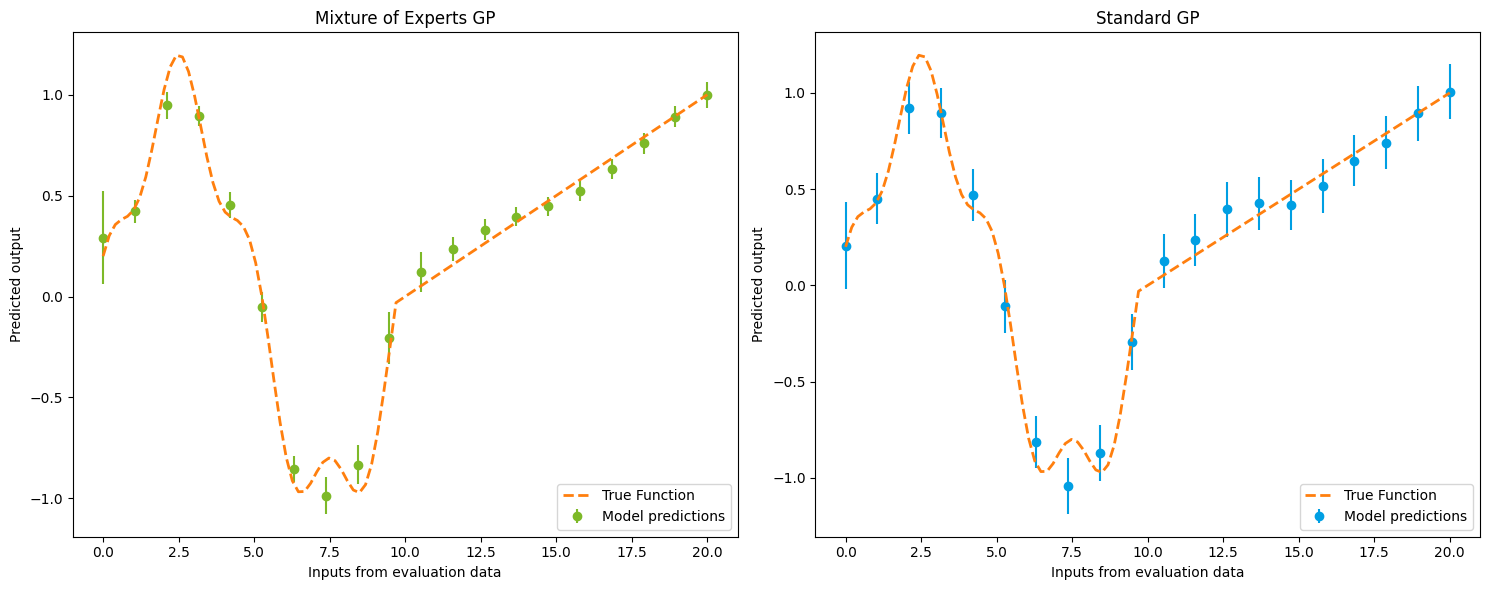

In [16]:
## Plot results
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Plot the predictions from the MoE GP as points with error bars
axes[0].errorbar(
    eval_df["X"],
    eval_df["mean_predictions_MoE"],
    yerr=eval_df["std_predictions_MoE"],
    fmt="o",
    color="#7DB928",
    label="Model predictions",
)
# Do the same for the standard GP
axes[1].errorbar(
    eval_df["X"],
    eval_df["mean_predictions"],
    yerr=eval_df["std_predictions"],
    fmt="o",
    color="#009FE3",
    label="Model predictions",
)
# Loop over the two to add information that is common to both
for ax_i in axes:
    # Plot the true function
    ax_i.plot(
        X,
        y,
        linewidth=2,
        label="True Function",
        color="tab:orange",
        linestyle="dashed",
        zorder=10,
    )
    # Add a legend and labels
    ax_i.legend(loc="lower right")
    ax_i.set_xlabel("Inputs from evaluation data")
    ax_i.set_ylabel("Predicted output")
# Add titles to the subplots
axes[0].set_title("Mixture of Experts GP")
axes[1].set_title("Standard GP")
# Display plots
plt.tight_layout()
plt.show()

The plot shows how the prediction uncertainty from the Mixture of Experts model is better calibrated than that from the Standard GP. This is most obvious when observing the predictions for the class 1 region ($X>9.7$). In this region the magnitude of the uncertainty has significantly decreased whilst the predictions remain statistically consistent with the true function.

### **Deleting datasets and campaigns**

You can delete your datasets and emulators to keep your twinLab cloud account storage tidy. 

Please be aware that this is permanent. Always consider keeping your data locally backed up. 

`Emulator.delete` and `Dataset.delete` delete the emulator and the dataset respectively.

In [17]:
# Delete standard emulator and dataset
emulator.delete()
dataset.delete()

# Delete MoE emulator
emulator_MoE.delete()